In [ ]:
import pandas as pd
import numpy as np
import os
import geopy
import datetime as dt
import datetime
from datetime import datetime as dt
from geopy.geocoders import Nominatim
from scipy.stats import norm

print(os.getcwd())

#Reading excel dataset into python using pandas
data = pd.read_excel("Dataset.xlsx")

data.columns

/content


Index(['Annonymized ID', 'Employee Status', 'Employee Type',
       'Current Hire Date', 'Continuous Service Date', 'Termination Date',
       'Years of Service', 'Term Category', 'Termination Reason', 'Location',
       'Country', 'Region', 'Job Code', 'Job Title', 'Job Category',
       'Job Function', 'Job Family', 'Management Level', 'Pay Level',
       'Work Structure ', 'Pay Grade', 'Organization', 'Compa Ratio',
       'Marital Status', 'Age', 'Generation', 'Race/Ethnicity', 'Gender',
       'Base Pay Mid Point', 'Last Promotion Date', 'Cost to Replace Factor'],
      dtype='object')

In [ ]:
data.head()

,Annonymized ID,Employee Status,Employee Type,Current Hire Date,Continuous Service Date,Termination Date,Years of Service,Term Category,Termination Reason,Location,...,Organization,Compa Ratio,Marital Status,Age,Generation,Race/Ethnicity,Gender,Base Pay Mid Point,Last Promotion Date,Cost to Replace Factor
0,1111,Terminated,Regular,1991-04-29,1991-04-29,2020-08-04,29.3,Involuntary Termination,Position Elimination / RIF Involuntary,Shakopee United States,...,NaN,0.841,Married,59,Boomer,"White, not Hispanic or Latino",Male,250036.80,2003-09-22,1.25
1,1112,Terminated,Regular,1993-07-01,1993-07-01,2018-07-11,25.0,Voluntary Termination,Change of Career Direction,Woodlands Singapore W3,...,NaN,1.017,Married,54,Gen X,Chinese,Male,203097.98,2010-07-01,1.25
2,1113,Terminated,Regular,1989-07-05,1989-07-05,2017-09-22,28.2,Involuntary Termination,Position Elimination / RIF Voluntary,Penang Malaysia,...,NaN,0.890,Married,58,Boomer,Chinese,Female,50178.00,NaT,1.25
3,1114,Active,Regular,1984-02-15,1984-02-15,NaT,38.8,NaN,NaN,Ayer Rajah Crescent Singapore,...,Account Management,1.070,Married,56,Gen X,Chinese,Female,56514.22,NaT,1.25
4,1115,Terminated,Regular,1987-04-22,1987-04-22,2018-09-14,31.4,Involuntary Termination,Position Elimination / RIF Involuntary,Ayer Rajah Crescent Singapore,...,Account Management,0.788,Married,64,Boomer,Chinese,Female,92718.64,2011-07-01,1.25


In [ ]:
data.dtypes

Annonymized ID                      int64
Employee Status                    object
Employee Type                      object
Current Hire Date          datetime64[ns]
Continuous Service Date    datetime64[ns]
Termination Date           datetime64[ns]
Years of Service                  float64
Term Category                      object
Termination Reason                 object
Location                           object
Country                            object
Region                             object
Job Code                           object
Job Title                          object
Job Category                       object
Job Function                       object
Job Family                         object
Management Level                   object
Pay Level                          object
Work Structure                     object
Pay Grade                          object
Organization                       object
Compa Ratio                       float64
Marital Status                    

In [ ]:
#keeping only necessary data
#there are few unpaid leave category people; need to deal with them
data=data[(data['Term Category']=='Voluntary Termination')|(pd.isnull(data['Term Category']))]
data.reset_index(drop=True,inplace=True)

#cleaning col names; removing trailing spaces, lowercase and underscore instead of space
data.columns=[x.strip().lower().replace(" ","_") for x in data.columns]
data.columns

#dropping unnecessary columns
#Dropping id, pay grade (pay level + location); job code can be determined from a mix of location, job title and other columns
#we can drop location too maybe? as we have latitude and longitude
#TODO: need to drop termination date, term category, and termination reson, any var that can predict employee status
#We can club reasons and build a multi class model, or build a second model on only terminated employees to predict a 3 class termination reason
data.drop(['annonymized_id','pay_grade','job_code'], axis=1, inplace=True)
data.head()

,employee_status,employee_type,current_hire_date,continuous_service_date,termination_date,years_of_service,term_category,termination_reason,location,country,...,organization,compa_ratio,marital_status,age,generation,race/ethnicity,gender,base_pay_mid_point,last_promotion_date,cost_to_replace_factor
0,Terminated,Regular,1993-07-01,1993-07-01,2018-07-11,25.0,Voluntary Termination,Change of Career Direction,Woodlands Singapore W3,Singapore,...,NaN,1.017,Married,54,Gen X,Chinese,Male,203097.98,2010-07-01,1.25
1,Active,Regular,1984-02-15,1984-02-15,NaT,38.8,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,Account Management,1.070,Married,56,Gen X,Chinese,Female,56514.22,NaT,1.25
2,Active,Regular,1989-07-26,1989-07-26,NaT,33.4,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,Account Management,0.888,Married,61,Boomer,Chinese,Female,127157.00,2003-10-01,1.25
3,Active,Regular,1994-04-11,1994-04-11,NaT,28.7,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,Account Management,0.975,Married,55,Gen X,Chinese,Female,83888.30,2013-02-05,1.25
4,Active,Regular,1995-09-11,1995-09-11,NaT,27.3,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,Account Management,0.951,Married,50,Gen X,Chinese,Female,92718.64,2011-10-01,1.25


In [ ]:
data.shape

(20427, 28)

In [ ]:
#For our analysis
#Separating numerical and categorical columns

num_cols=[]
cat_cols=[]
date_cols=[]
for x in data.columns:
  if data[x].dtype=='object':
    cat_cols.append(x)
  elif len(set(data[x]))<10:
    cat_cols.append(x)
  elif 'date' not in x:
    num_cols.append(x)
  else:
    date_cols.append(x)
    

In [ ]:
#num_cols
num_cols

['years_of_service', 'compa_ratio', 'age', 'base_pay_mid_point']

In [ ]:
date_cols

['current_hire_date',
 'continuous_service_date',
 'termination_date',
 'last_promotion_date']

In [ ]:
cat_cols

['employee_status',
 'employee_type',
 'term_category',
 'termination_reason',
 'location',
 'country',
 'region',
 'job_title',
 'job_category',
 'job_function',
 'job_family',
 'management_level',
 'pay_level',
 'work_structure',
 'organization',
 'marital_status',
 'generation',
 'race/ethnicity',
 'gender',
 'cost_to_replace_factor']

**Step 1: Removing Duplicates**

In [ ]:
#Removing Duplicates
data.drop_duplicates()
print(sum(data.duplicated()))

5


**Step 2: Handling missing data**

In [ ]:
#Handling missing data
#Dropping the value where base pay mid point is 0
data.drop(data.loc[data['base_pay_mid_point'] == 0].index, inplace=True)

In [ ]:
#Thoughts on the following?
#  8984 rows with 'Work Structure' = NULL - lots of null values, should the column be dropped?
# we could tag them as missing and use them to train the model. That way we can retain info
data['work_structure'] = data['work_structure'].fillna('Missing')

data['race/ethnicity'] = data['race/ethnicity'].fillna('Non-Disclosed')

**Step 3: Standardizing data formats**

In [ ]:
#All dates are in MM/DD/YYYY format - should it be converted into MM/YY to reduce variance?
#Either the above or keep it as YY; as we can then encode that var to use in models


In [ ]:
data['work_structure'].value_counts()

Onsite     14530
Missing     4783
Remote       590
Hybrid       523
Name: work_structure, dtype: int64

In [ ]:
data['race/ethnicity'].value_counts()

Thai                                                                 5193
Non-Disclosed                                                        4822
Chinese                                                              3170
White, not Hispanic or Latino                                        2963
Asian, not Hispanic or Latino                                        1651
Malay                                                                1011
Indian                                                                696
others                                                                370
Hispanic or Latino                                                    217
Black or African-American, not Hispanic or Latino                     105
Two or More Races, not Hispanic or Latino                              71
Others                                                                 41
Filipino                                                               38
I do not wish to disclose             

**Step 4: Addressing outliers**

In [ ]:
for col in num_cols:

  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # replace outliers with upper or lower bound
  data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
  data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])




**Step 6: Transforming data**

*   'Term Category' : Only values where 'Term Category' = Voluntary Termination  or blanks are kept.
*   Dropping columns like 'Annonymized ID', 'Job Code', 'Organization','Pay Grade' due to high variance.



In [ ]:
#these are categorical columns with high variance; creating new binned cols for them; see below
mod=[]

for x in cat_cols:
  if len(data[x].value_counts())>20:
    mod.append(x)
  else:
    print('Not modding')
    print(x,len(data[x].value_counts()))

Not modding
employee_status 3
Not modding
employee_type 2
Not modding
term_category 1
Not modding
termination_reason 15
Not modding
region 3
Not modding
job_category 12
Not modding
management_level 6
Not modding
work_structure 4
Not modding
marital_status 10
Not modding
generation 4
Not modding
gender 4
Not modding
cost_to_replace_factor 3


In [ ]:
data.columns

Index(['employee_status', 'employee_type', 'current_hire_date',
       'continuous_service_date', 'termination_date', 'years_of_service',
       'term_category', 'termination_reason', 'location', 'country', 'region',
       'job_title', 'job_category', 'job_function', 'job_family',
       'management_level', 'pay_level', 'work_structure', 'organization',
       'compa_ratio', 'marital_status', 'age', 'generation', 'race/ethnicity',
       'gender', 'base_pay_mid_point', 'last_promotion_date',
       'cost_to_replace_factor'],
      dtype='object')

In [ ]:
mod

['location',
 'country',
 'job_title',
 'job_function',
 'job_family',
 'pay_level',
 'organization',
 'race/ethnicity']

In [ ]:
#Binning based on quartiles
for col in mod:
    # Fill null values
    data[col].fillna('NA', inplace=True)

    # Get value counts of each category
    value_counts = data[col].value_counts()

    # Define bins based on quartiles
    bins = [0, value_counts.quantile(0.25), value_counts.quantile(0.5), value_counts.quantile(0.75), np.inf]
    labels = ['Q1', 'Q2', 'Q3', 'Q4']

    # Creating new variable name for the binned data
    new_var = col + '_q_binned'

    # Bin categories based on quartiles
    data[new_var] = pd.cut(data[col].map(value_counts), bins=bins, labels=labels, include_lowest=True)

In [ ]:
data.head()

,employee_status,employee_type,current_hire_date,continuous_service_date,termination_date,years_of_service,term_category,termination_reason,location,country,...,last_promotion_date,cost_to_replace_factor,location_q_binned,country_q_binned,job_title_q_binned,job_function_q_binned,job_family_q_binned,pay_level_q_binned,organization_q_binned,race/ethnicity_q_binned
0,Terminated,Regular,1993-07-01,1993-07-01,2018-07-11,25.00,Voluntary Termination,Change of Career Direction,Woodlands Singapore W3,Singapore,...,2010-07-01,1.25,Q4,Q4,Q4,Q4,Q4,Q3,Q1,Q4
1,Active,Regular,1984-02-15,1984-02-15,NaT,37.25,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,NaT,1.25,Q4,Q4,Q4,Q3,Q4,Q4,Q4,Q4
2,Active,Regular,1989-07-26,1989-07-26,NaT,33.40,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,2003-10-01,1.25,Q4,Q4,Q4,Q3,Q4,Q4,Q4,Q4
3,Active,Regular,1994-04-11,1994-04-11,NaT,28.70,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,2013-02-05,1.25,Q4,Q4,Q3,Q3,Q4,Q4,Q4,Q4
4,Active,Regular,1995-09-11,1995-09-11,NaT,27.30,NaN,NaN,Ayer Rajah Crescent Singapore,Singapore,...,2011-10-01,1.25,Q4,Q4,Q4,Q3,Q4,Q3,Q4,Q4


In [ ]:
#Looks ok i think
data['organization_q_binned'].value_counts()

Q4    17175
Q3     2133
Q2      759
Q1      359
Name: organization_q_binned, dtype: int64

In [ ]:
data['organization'].value_counts()

Media Test & MDW Engineering                      1018
Media Equipment Engineering                        868
Slider Engineering                                 738
Equipment Engineering                              528
Media Research & Development                       524
                                                  ... 
Products, Supply and Demand Operations               1
Product Security Ops and Engineering                 1
Global Accounting / EMEA & AMER Controllership       1
Global Accounting / EMEA Controllership / UK         1
NA                                                   1
Name: organization, Length: 632, dtype: int64

In [ ]:
print(data.isnull().sum())

employee_status                0
employee_type                  0
current_hire_date              0
continuous_service_date        0
termination_date           14835
years_of_service               0
term_category              14836
termination_reason         14836
location                       0
country                        0
region                         0
job_title                      0
job_category                   0
job_function                   0
job_family                     0
management_level               0
pay_level                      0
work_structure                 0
organization                   0
compa_ratio                    0
marital_status               334
age                            0
generation                     0
race/ethnicity                 0
gender                         0
base_pay_mid_point             0
last_promotion_date         8391
cost_to_replace_factor         0
location_q_binned              0
country_q_binned               0
job_title_

# Feature Engineering

In [ ]:
#Cleaning locations and adding city, long lat
data['location'][data['location'].apply(lambda x:'pune' in x.lower())]='Pune India'
data['location'][data['location'].apply(lambda x:'thepharuk' in x.lower())]='Thepharak Thailand'
a=list(set(data['location']))
lat=[]
longi=[]
missing=[]
for i in a:
    geolocator = Nominatim(user_agent='adi')
    location = geolocator.geocode(i, timeout=100000, language = 'en')
    try:
        lat.append(location.latitude)
        longi.append(location.longitude)
    except:
        missing.append(i)

print(missing)

df2=pd.DataFrame({'location':a,'lat':lat,'longi':longi})
#appending latitude and logitude to original dataframe; can use lat, long in models instead of one-hot encoding the location var
data=pd.merge(data,df2,on='location',how='outer')

<ipython-input-25-9d98a894f89e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['location'][data['location'].apply(lambda x:'pune' in x.lower())]='Pune India'
<ipython-input-25-9d98a894f89e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['location'][data['location'].apply(lambda x:'thepharuk' in x.lower())]='Thepharak Thailand'


[]


In [ ]:
#!pip install geopy


In [ ]:
#1. Annonymized ID has to be dropped while performing analysis - due to high variance
#2. Check if Employees with 'Employee Type' = Fixed Term has to be kept - All records are terminated due to both voluntary and involuntary reasons. 
#Contract based employment, total records = 16, might be removed from our analysis
#3. One row has 'Base Pay Mid Point Annualized USD' = 0: anomaly/ outlier?
  #Handled in Section 2
#4. 'Pay Grade': Has less meaning, redundant and is covered as part of 'Pay Level' + location, hence can be dropped
#5. 8984 rows with 'Work Structure' = NULL - lots of null values, should the column be dropped? Chill, we'll keep them
#6 Already done - Only Voluntary termination and blank values are kept in 'Term Category'
#7. All dates are in MM/DD/YYYY format - should it be converted into MM/YY to reduce variance?
#8. Missing values in Race/ Ethnicity - Can be converted to 'I do not wish to disclose'

In [ ]:

data.columns

Index(['employee_status', 'employee_type', 'current_hire_date',
       'continuous_service_date', 'termination_date', 'years_of_service',
       'term_category', 'termination_reason', 'location', 'country', 'region',
       'job_title', 'job_category', 'job_function', 'job_family',
       'management_level', 'pay_level', 'work_structure', 'organization',
       'compa_ratio', 'marital_status', 'age', 'generation', 'race/ethnicity',
       'gender', 'base_pay_mid_point', 'last_promotion_date',
       'cost_to_replace_factor', 'location_q_binned', 'country_q_binned',
       'job_title_q_binned', 'job_function_q_binned', 'job_family_q_binned',
       'pay_level_q_binned', 'organization_q_binned',
       'race/ethnicity_q_binned', 'lat', 'longi'],
      dtype='object')

In [ ]:
#Adding Salary as a feature
data['salary'] = data['compa_ratio']*data['base_pay_mid_point']
data['salary']

0        204243.37776
1         21546.04912
2         39012.47220
3         53292.90946
4         18190.51688
             ...     
20421    226577.20800
20422    230042.28000
20423    115991.07520
20424    135758.68800
20425    120493.65120
Name: salary, Length: 20426, dtype: float64

In [ ]:
#Adding Replacement Cost
data['replacement_cost'] = data['salary']*data['cost_to_replace_factor']

In [ ]:
#Adding time since last promotion
basedate = pd.Timestamp('2023-01-01')
data['days_since_promotion'] = basedate- data['last_promotion_date']
data['days_since_promotion'] = data['days_since_promotion'].dt.days

In [ ]:
data.to_excel('denorm_data.xlsx')

In [ ]:
# normalize using normal distribution
num_cols=[]
cat_cols=[]
for x in data.columns:
  if data[x].dtype=='object':
    cat_cols.append(x)
  elif len(set(data[x]))<10:
    cat_cols.append(x)
  elif 'date' not in x:
    num_cols.append(x)

for col in num_cols:
  mu = data[col].mean()
  sigma = data[col].std()
  data[col] = norm.cdf((data[col] - mu) / sigma)

In [ ]:
df = data.copy()
df.head()

,employee_status,employee_type,current_hire_date,continuous_service_date,termination_date,years_of_service,term_category,termination_reason,location,country,...,job_function_q_binned,job_family_q_binned,pay_level_q_binned,organization_q_binned,race/ethnicity_q_binned,lat,longi,salary,replacement_cost,days_since_promotion
0,Terminated,Regular,1993-07-01,1993-07-01,2018-07-11,0.936786,Voluntary Termination,Change of Career Direction,Woodlands Singapore W3,Singapore,...,Q4,Q4,Q3,Q1,Q4,0.108812,0.748922,0.997760,0.995886,0.90612
1,Terminated,Regular,2012-04-23,2012-04-23,2017-10-30,0.265960,Voluntary Termination,Compensation/Pay,Woodlands Singapore W3,Singapore,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.257672,0.228553,NaN
2,Terminated,Regular,2012-05-17,2012-05-17,2017-09-18,0.258763,Voluntary Termination,Career Advancement,Woodlands Singapore W3,Singapore,...,Q4,Q4,Q4,Q4,Q4,0.108812,0.748922,0.375765,0.413903,NaN
3,Terminated,Regular,2012-11-15,2012-11-15,2021-04-09,0.380249,Voluntary Termination,Return Home/Care for Family,Woodlands Singapore W3,Singapore,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.482606,0.511835,NaN
4,Terminated,Regular,2014-04-28,2014-04-28,2018-04-21,0.214552,Voluntary Termination,Return Home/Care for Family,Woodlands Singapore W3,Singapore,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.237401,0.221584,NaN


In [ ]:
#Dataset 2: Copy of dataset with categorical columns as a reference to the binned values
data.to_excel('CleanData_ForPresentation_No_Normalization.xlsx')

In [ ]:
data.shape

(20426, 41)

In [ ]:
df.drop(['location', 'country', 'region','job_title', 'job_function', 'job_family','pay_level', 'organization','race/ethnicity']
               , axis=1, inplace=True)

In [ ]:
#df = df.round(2)

In [ ]:
df.head()

,employee_status,employee_type,current_hire_date,continuous_service_date,termination_date,years_of_service,term_category,termination_reason,job_category,management_level,...,job_function_q_binned,job_family_q_binned,pay_level_q_binned,organization_q_binned,race/ethnicity_q_binned,lat,longi,salary,replacement_cost,days_since_promotion
0,Terminated,Regular,1993-07-01,1993-07-01,2018-07-11,0.936786,Voluntary Termination,Change of Career Direction,Management,Director,...,Q4,Q4,Q3,Q1,Q4,0.108812,0.748922,0.997760,0.995886,0.90612
1,Terminated,Regular,2012-04-23,2012-04-23,2017-10-30,0.265960,Voluntary Termination,Compensation/Pay,Operations Support,Support,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.257672,0.228553,NaN
2,Terminated,Regular,2012-05-17,2012-05-17,2017-09-18,0.258763,Voluntary Termination,Career Advancement,Engineering Professional,Professional,...,Q4,Q4,Q4,Q4,Q4,0.108812,0.748922,0.375765,0.413903,NaN
3,Terminated,Regular,2012-11-15,2012-11-15,2021-04-09,0.380249,Voluntary Termination,Return Home/Care for Family,Engineering Professional,Professional,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.482606,0.511835,NaN
4,Terminated,Regular,2014-04-28,2014-04-28,2018-04-21,0.214552,Voluntary Termination,Return Home/Care for Family,Operations Support,Support,...,Q4,Q4,Q4,Q4,Q3,0.108812,0.748922,0.237401,0.221584,NaN


In [ ]:
df.dtypes

employee_status                    object
employee_type                      object
current_hire_date          datetime64[ns]
continuous_service_date    datetime64[ns]
termination_date           datetime64[ns]
years_of_service                  float64
term_category                      object
termination_reason                 object
job_category                       object
management_level                   object
work_structure                     object
compa_ratio                       float64
marital_status                     object
age                               float64
generation                         object
gender                             object
base_pay_mid_point                float64
last_promotion_date        datetime64[ns]
cost_to_replace_factor            float64
location_q_binned                category
country_q_binned                 category
job_title_q_binned               category
job_function_q_binned            category
job_family_q_binned              c

In [ ]:
#df.to_excel('CleanData_ForModeling.xlsx')


In [ ]:
#this should've been done in the data cleaning step, Nehal can you add this to our later reports/ppt as part of data cleaning?
df=df[((df['term_category'].isna())&(df['employee_status']=='Active'))|((df['term_category']=='Voluntary Termination')&(df['employee_status']=='Terminated'))]
#output var creation
df['employee_status']=df['employee_status'].apply(lambda x: 1 if x=='Terminated' else 0)

<ipython-input-42-9fcc0e1d6b66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employee_status']=df['employee_status'].apply(lambda x: 1 if x=='Terminated' else 0)


In [ ]:
#these vars can directly predict output variable; need to drop them for sure
#work structure has a very high correlation with the output, hence dropped. base_pay_mid_point has high correlation with Salary, hence dropped
df.drop(['term_category','termination_reason','termination_date','last_promotion_date','work_structure','base_pay_mid_point'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
#Changing date columns to years
#Should've been in data cleaning too 

for d in [col for col in df.columns if 'date' in col]:
    df[d]=df[d].apply(lambda x: str(x.year))

#Binning data based on quartiles
#dropping old columns here
for col in [col for col in df.columns if 'date' in col]:
    print(col)
    # Fill null values
    df[col].fillna('NA', inplace=True)

    # Get value counts of each category
    value_counts = df[col].value_counts()

    # Define bins based on quartiles
    bins = [0, value_counts.quantile(0.25), value_counts.quantile(0.5), value_counts.quantile(0.75), np.inf]
    labels = ['Q1', 'Q2', 'Q3', 'Q4']

    # Creating new variable name for the binned data
    new_var = col + '_q_binned'

    # Bin categories based on quartiles
    df[new_var] = pd.cut(df[col].map(value_counts), bins=bins, labels=labels, include_lowest=True)
    
    #dropping old date columns
    #TODO - need to map quartiles to old years to understand 
    df.drop(col,axis=1,inplace=True)
    print(new_var)

<ipython-input-44-4b93c384eaca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[d]=df[d].apply(lambda x: str(x.year))


current_hire_date
current_hire_date_q_binned
continuous_service_date
continuous_service_date_q_binned


In [ ]:
# More data cleaning steps; need to add as having been done before in data cleaning report
df['days_since_promotion'][df['days_since_promotion'].isna()]=-1
df['marital_status'][df['marital_status'].isna()]='NA'

<ipython-input-45-86f233222a1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_promotion'][df['days_since_promotion'].isna()]=-1
<ipython-input-45-86f233222a1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital_status'][df['marital_status'].isna()]='NA'


In [ ]:
#Creating dummies and replacing them in the original data


num_cols=[]
cat_cols=[]
for x in df.columns:  
    if df[x].dtype=='object':
        cat_cols.append(x)
    elif len(set(df[x]))<10:
        cat_cols.append(x)
    else:
        num_cols.append(x)
        
print(num_cols)
print(cat_cols)


#Getting dummies for variables, drop old ones
for var in cat_cols:
    if var not in ['employee_status','cost_to_replace_factor']:
        dummies = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(var,axis=1,inplace=True)

['years_of_service', 'compa_ratio', 'age', 'lat', 'longi', 'salary', 'replacement_cost', 'days_since_promotion']
['employee_status', 'employee_type', 'job_category', 'management_level', 'marital_status', 'generation', 'gender', 'cost_to_replace_factor', 'location_q_binned', 'country_q_binned', 'job_title_q_binned', 'job_function_q_binned', 'job_family_q_binned', 'pay_level_q_binned', 'organization_q_binned', 'race/ethnicity_q_binned', 'current_hire_date_q_binned', 'continuous_service_date_q_binned']


In [ ]:
df.columns

Index(['employee_status', 'years_of_service', 'compa_ratio', 'age',
       'cost_to_replace_factor', 'lat', 'longi', 'salary', 'replacement_cost',
       'days_since_promotion', 'employee_type_Regular',
       'job_category_Engineering Support', 'job_category_Executive',
       'job_category_Management', 'job_category_Operations Support',
       'job_category_Professional', 'job_category_Sales Management',
       'job_category_Sales Reps', 'job_category_Service Workers',
       'job_category_Skilled Craft Workers', 'job_category_Supervisors',
       'job_category_Support', 'management_level_Executive',
       'management_level_Manager', 'management_level_Professional',
       'management_level_Supervisor', 'management_level_Support',
       'marital_status_Domestic Partner',
       'marital_status_Domestic Partner (Unregistered Marriage)',
       'marital_status_Legally Separated', 'marital_status_Living Together',
       'marital_status_Married', 'marital_status_NA', 'marital_status_S

In [ ]:
# calculate correlation matrix
corr_matrix = df.corr()

# display correlation matrix with just the correlations for the target variable
# sort correlation matrix by correlations with the target variable, in descending order
corr_matrix_sorted = corr_matrix['employee_status'].sort_values(ascending=False)

# display sorted correlation matrix
print(corr_matrix_sorted)

employee_status                        1.000000
current_hire_date_q_binned_Q4          0.221773
continuous_service_date_q_binned_Q4    0.211249
generation_Millennial                  0.188630
management_level_Professional          0.128689
                                         ...   
current_hire_date_q_binned_Q3         -0.152837
age                                   -0.172530
days_since_promotion                  -0.236471
compa_ratio                           -0.273367
years_of_service                      -0.362392
Name: employee_status, Length: 73, dtype: float64


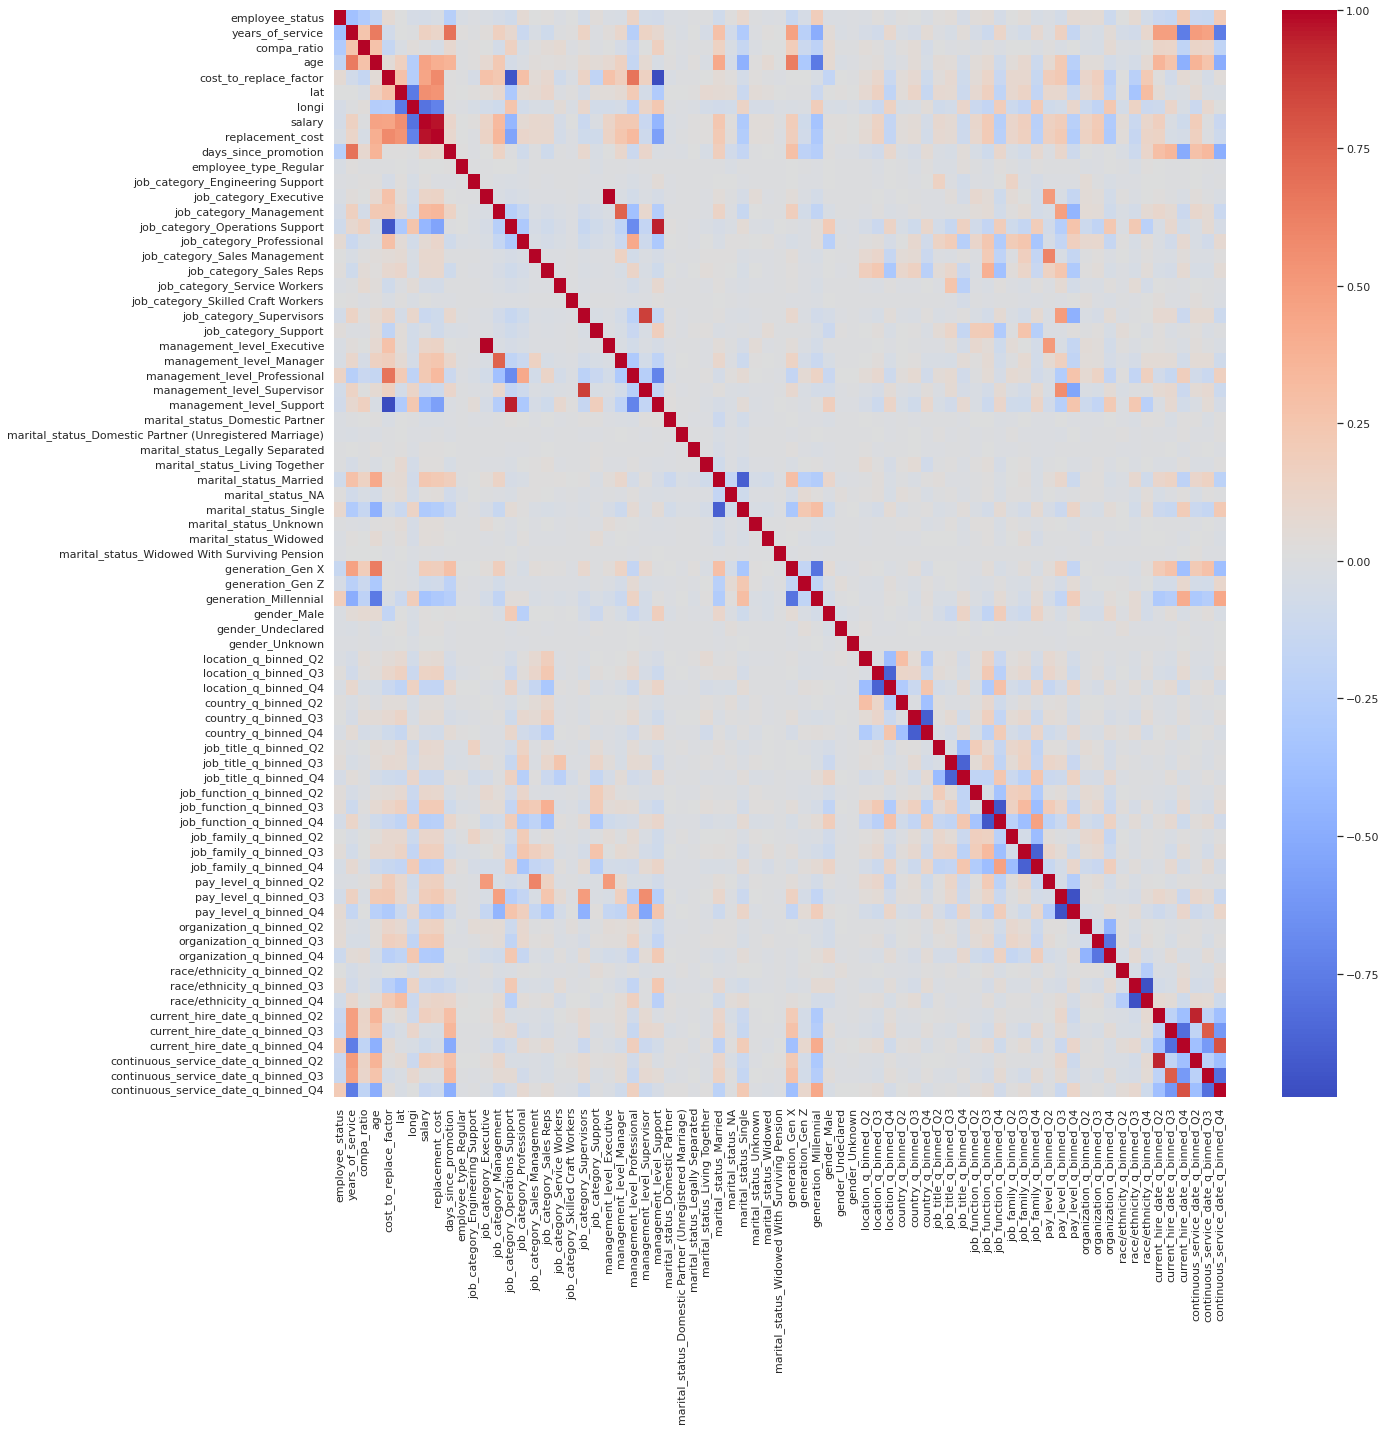

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set style and color palette
sns.set(style="white")
sns.set_palette("coolwarm")

# Create heatmap with correlation matrix
fig, ax = plt.subplots(figsize=(20,20))
# plot correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap="coolwarm")
# show the plot
plt.show()

In [ ]:
#Creating clean dataset for modeling
df.to_excel('ModelingDataset.xlsx')

In [ ]:
df.shape

(20321, 73)

# New Section